In [1]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

# 1️⃣ Recreate the model architecture exactly the same way:
def get_model(num_classes):
    model = retinanet_resnet50_fpn_v2(pretrained=True)
    in_feat = model.head.classification_head.conv[0][0].in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(
        in_feat, num_anchors, num_classes
    )
    return model

# 2️⃣ Build the model instance:
model = get_model(num_classes=5)

# 3️⃣ Load the weights:
model.load_state_dict(torch.load("retinanet_rsod.pth"))

# 4️⃣ Put it in eval mode:
model.eval()



/home/saku/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saku/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [2]:
from PIL import Image
import torchvision.transforms as T

# Load an image
img = Image.open("/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/aircraft_34.jpg").convert("RGB")

# Apply same preprocessing:
transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img).unsqueeze(0)  # add batch dim

# Run inference
model.to('cuda')
model.eval()
with torch.no_grad():
    preds = model(img_tensor.to('cuda'))

print(preds)


[{'boxes': tensor([[250.4984, 420.7271, 319.5449, 484.1815],
        [247.1264, 285.1325, 312.0273, 341.9603],
        [238.7424,  43.0623, 298.6405,  93.2236],
        [242.8002, 158.9173, 304.8606, 211.9477],
        [245.8779,  98.9848, 307.2550, 149.7303],
        [245.6907, 221.3123, 307.5374, 276.3661],
        [241.4793, 113.9826, 305.5027, 196.7573],
        [247.6962, 245.1766, 311.8262, 330.4452],
        [242.4607, 178.1432, 305.1221, 264.2701],
        [107.8601,   0.6114, 125.6714,  23.8463],
        [278.1945, 101.4082, 306.3001, 139.9649],
        [276.6110, 289.0256, 313.8529, 325.7935],
        [256.4225, 101.5233, 306.4490, 131.5212],
        [291.1835, 292.8908, 310.5526, 320.9596],
        [239.5439,  42.3445, 297.8684,  92.4094],
        [251.4177, 160.6706, 303.7741, 190.6437],
        [240.7832,  45.6682, 307.9356, 128.8344],
        [270.6025, 160.0720, 307.4242, 209.6017],
        [251.9665,  44.5317, 298.6051,  72.6828],
        [571.4895, 463.8519, 587.6977, 

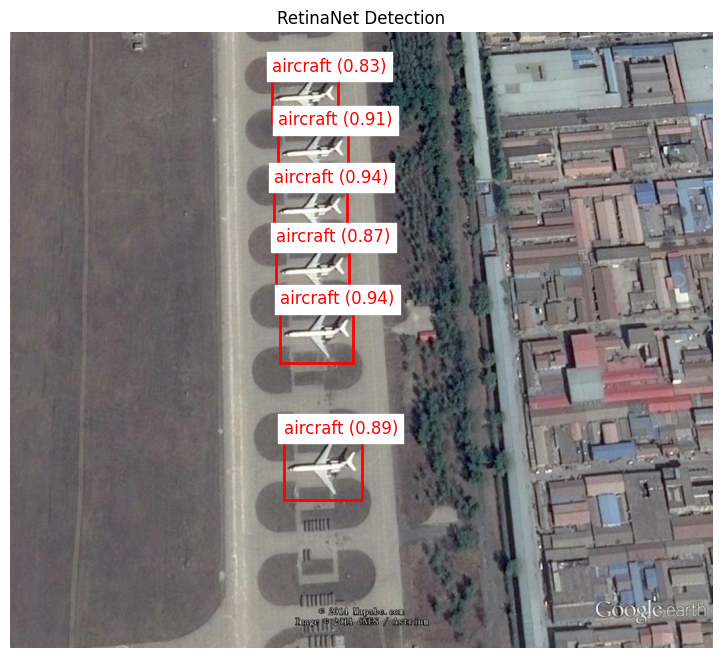

In [8]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 👇 Load image
image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/aircraft_34.jpg" 
# image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/oiltank_72.jpg"   # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# ✅ RSOD classes
class_names = ["__background__", "aircraft", "oiltank", "overpass", "playground"]

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{class_names[label]} ({score:.2f})", color='red',
            fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()


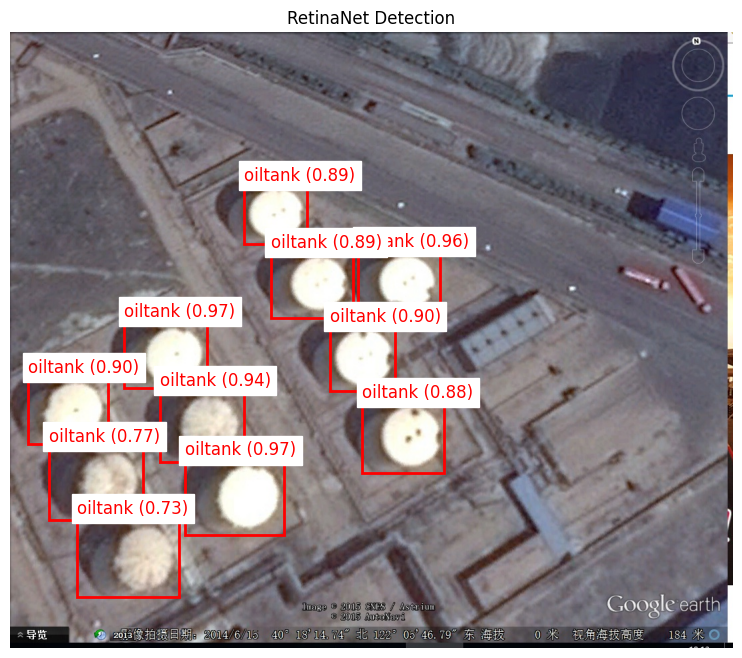

In [7]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 👇 Load image
# image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/aircraft_34.jpg" 
image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/oiltank_72.jpg"   # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# ✅ RSOD classes
class_names = ["__background__", "aircraft", "oiltank", "overpass", "playground"]

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{class_names[label]} ({score:.2f})", color='red',
            fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()


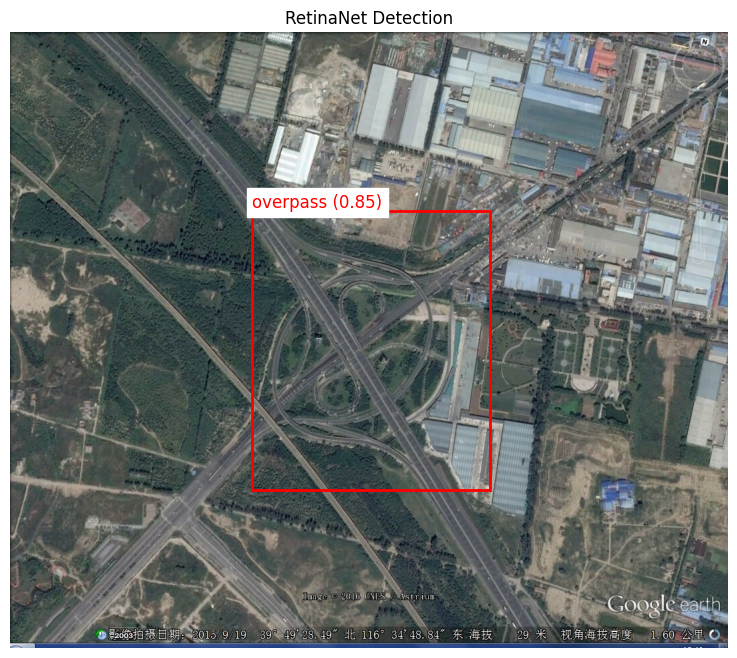

In [9]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 👇 Load image
# image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/aircraft_34.jpg" 
image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/overpass_54.jpg"   # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# ✅ RSOD classes
class_names = ["__background__", "aircraft", "oiltank", "overpass", "playground"]

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{class_names[label]} ({score:.2f})", color='red',
            fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()


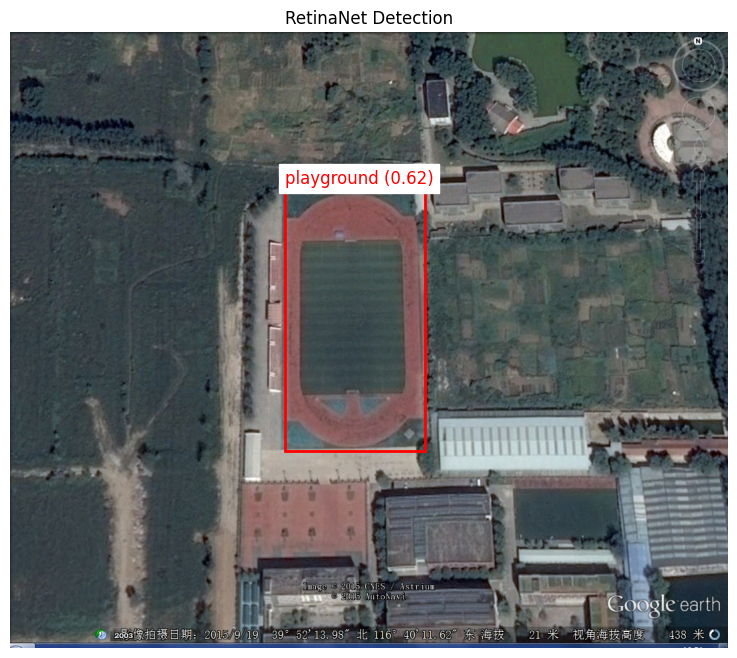

In [10]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 👇 Load image
# image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/aircraft_34.jpg" 
image_path = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images/playground_351.jpg"   # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# ✅ RSOD classes
class_names = ["__background__", "aircraft", "oiltank", "overpass", "playground"]

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{class_names[label]} ({score:.2f})", color='red',
            fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()
